In [ ]:
!pip install pymorphy2
!pip install --upgrade spacy
!python -m spacy download ru_core_news_sm

In [109]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pymorphy2
import re
import spacy
from spacy import displacy

import sqlite3


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Data

In [223]:
def txt2str(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        txt = re.sub(r'[,\-:;"*()\n]', '', f.read())
        txt = re.sub(r'[\.?!]', '.', txt)
    return txt.lower()

def table_sentence_id(text):
    sent_dict = {}
    for sent_id, item in enumerate(text.split('.')):
        sent_dict[sent_id] = item
    return sent_dict

def table_word_freq_dict(text):
    freq_dict = {}  
    for sent_id, item in enumerate(text.split('.')):
       for word in item.split():
           if word in freq_dict.keys():
               freq_dict[word] += 1
           else:
               freq_dict[word] = 1
    return freq_dict

def table_main(text):
    main = []
    for sent_id, item in enumerate(text.split('.')):
       for word in item.split():
           main.append((sent_id, word))
    return main

DB

sentence_id: table with all sentenses in the text + id

word_freq: table with worf forms + number of occurrences in the text

text: table with the text splited by words and sentences

In [224]:

my_text = txt2str('RB.txt')
#print(my_text)

con = sqlite3.connect("RB.db")
c = con.cursor()

sentence_id = table_sentence_id(my_text)
word_freq = table_word_freq_dict(my_text)

c.execute('DROP TABLE IF EXISTS sentence_id')
c.execute('CREATE TABLE IF NOT EXISTS sentence_id(sent_id, sent)')

for key in sentence_id.keys():
    c.execute('INSERT INTO sentence_id VALUES (?, ?)', (key, sentence_id[key]))

c.execute('DROP TABLE IF EXISTS word_freq')
c.execute('CREATE TABLE IF NOT EXISTS word_freq(word, word_n)')

for key in word_freq.keys():
    c.execute('INSERT INTO word_freq VALUES (?, ?)', (key, word_freq[key]))

text_main = table_main(my_text)

c.execute('DROP TABLE IF EXISTS text')
c.execute('CREATE TABLE IF NOT EXISTS text(sent_id, word)')

for word in text_main:
    c.execute('INSERT INTO text VALUES (?, ?)', (word[0], word[1]))

con.commit()
con.close()

Parsing

In [133]:
def db2df(query):
    con = sqlite3.connect('RB.db')
    my_df = pd.read_sql_query(query, con=con)
    return my_df

In [208]:
my_query = '''
SELECT sent, sent_id FROM sentence_id
'''

sentences_sub_df = db2df(my_query).head(100)  # remove .head(100)

my_query = '''
SELECT sent, text.word, word_n
FROM text
     JOIN sentence_id ON sentence_id.sent_id = text.sent_id
     JOIN word_freq ON word_freq.word = text.word
'''

rb_df = db2df(my_query)



In [203]:
def morphological_parsing_pos(word):
    return nltk.pos_tag([word])[0][1]

def syntactic_parsing(sent):
    nlp = spacy.load("en_core_web_sm")
    tokn_sent = nlp(sent)
    n_od_subj = [token.dep_ for token in tokn_sent].count('nsubj')
    if n_od_subj > 1:
        return 'COMPLEX'
    else:
        return 'SIMPLE'

def n_of_words_in_sent(sent):
    return len(sent.split())


In [209]:
rb_df['word_pos'] = rb_df['word'].apply(morphological_parsing_pos)
sentences_sub_df['sent_type'] = sentences_sub_df['sent'].apply(syntactic_parsing)
sentences_sub_df['sent_len'] = sentences_sub_df['sent'].apply(n_of_words_in_sent)


Plots

Text(0.5, 1.0, 'Dynamic of the sentence length from the beginning')

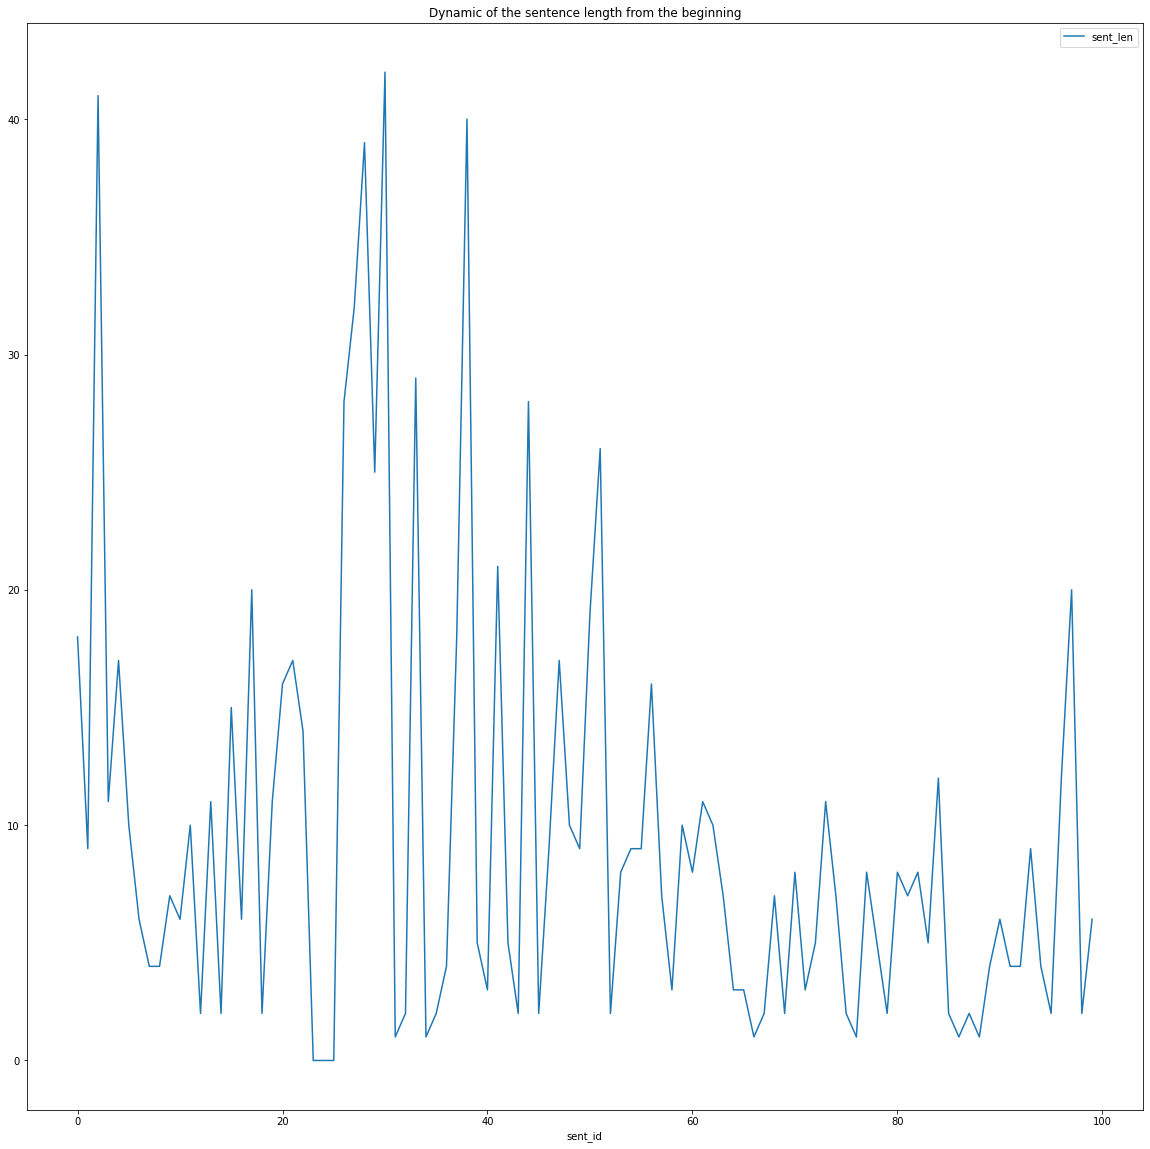

In [218]:
sentences_sub_df.sort_values('sent_id').plot(x='sent_id',y='sent_len', figsize=(20, 20))
plt.title('Dynamic of the sentence length from the beginning')

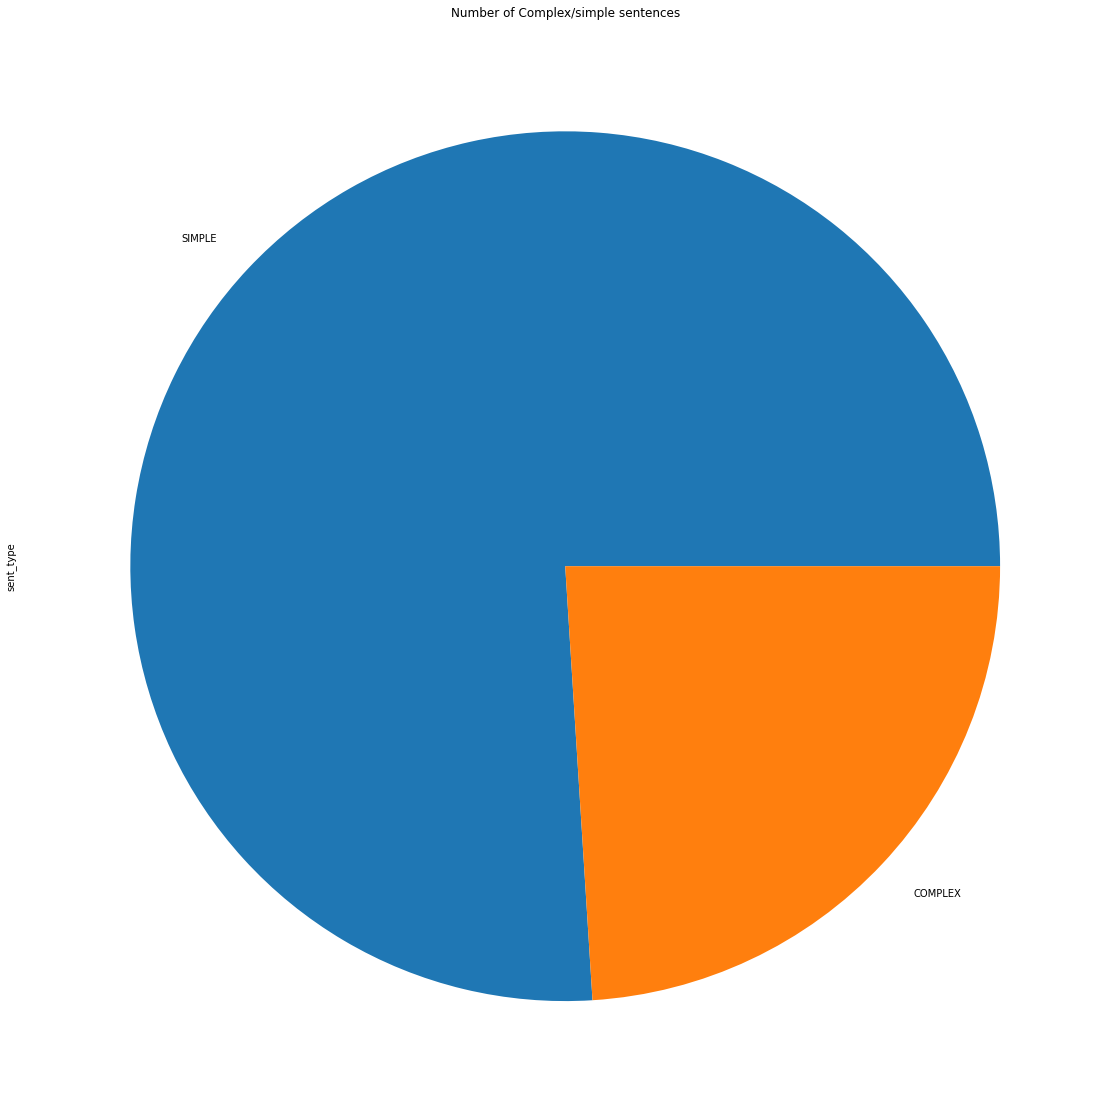

In [219]:
plt.figure(figsize=(20, 20))
plt.title('Number of Complex/simple sentences')
sentences_sub_df['sent_type'].value_counts().plot(kind='pie')

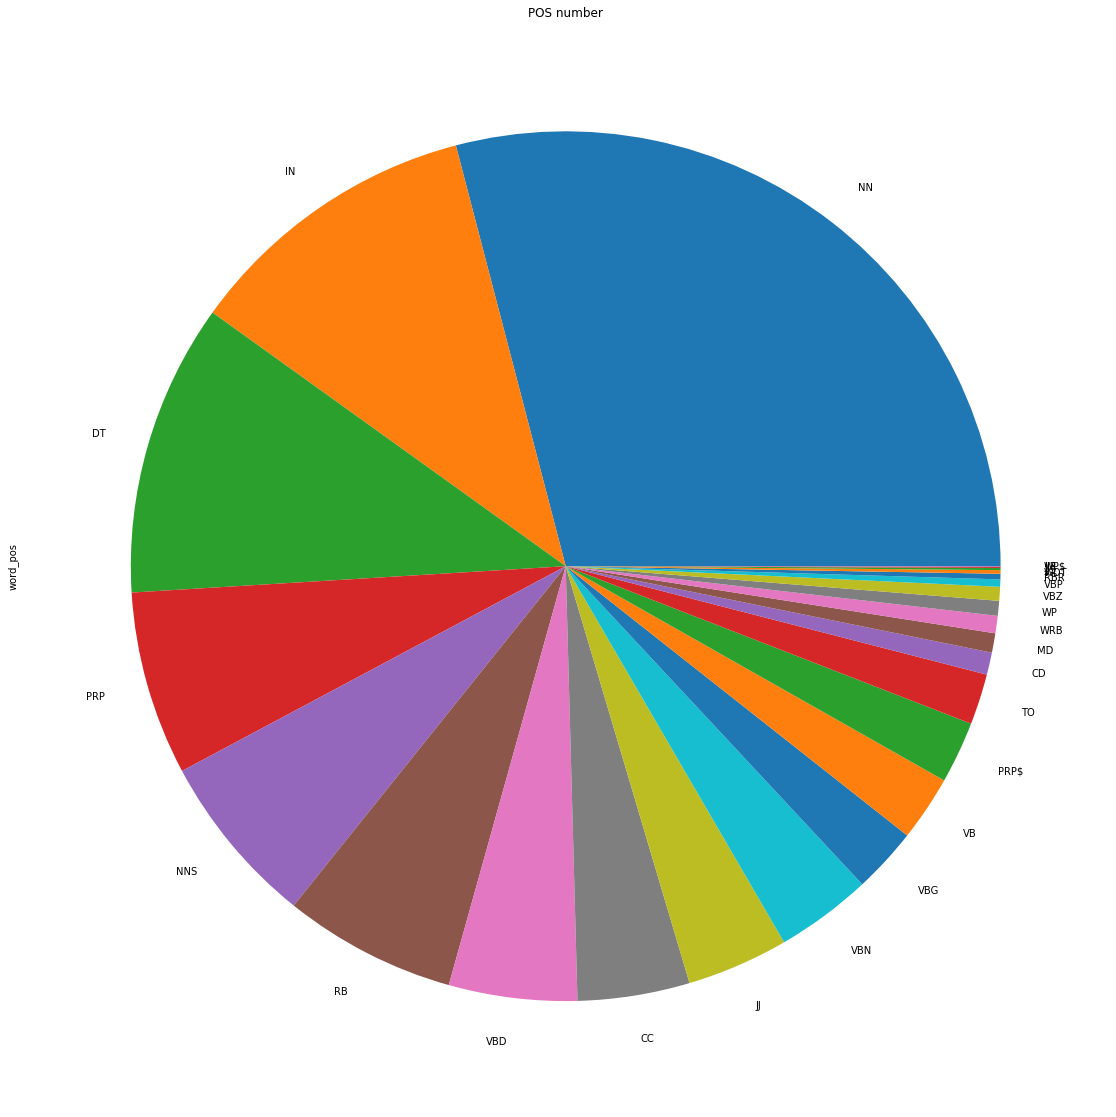

In [220]:
plt.figure(figsize=(20, 20))
plt.title('POS number')
rb_df['word_pos'].value_counts().plot(kind='pie')


Text(0.5, 1.0, 'TOP 30 words')

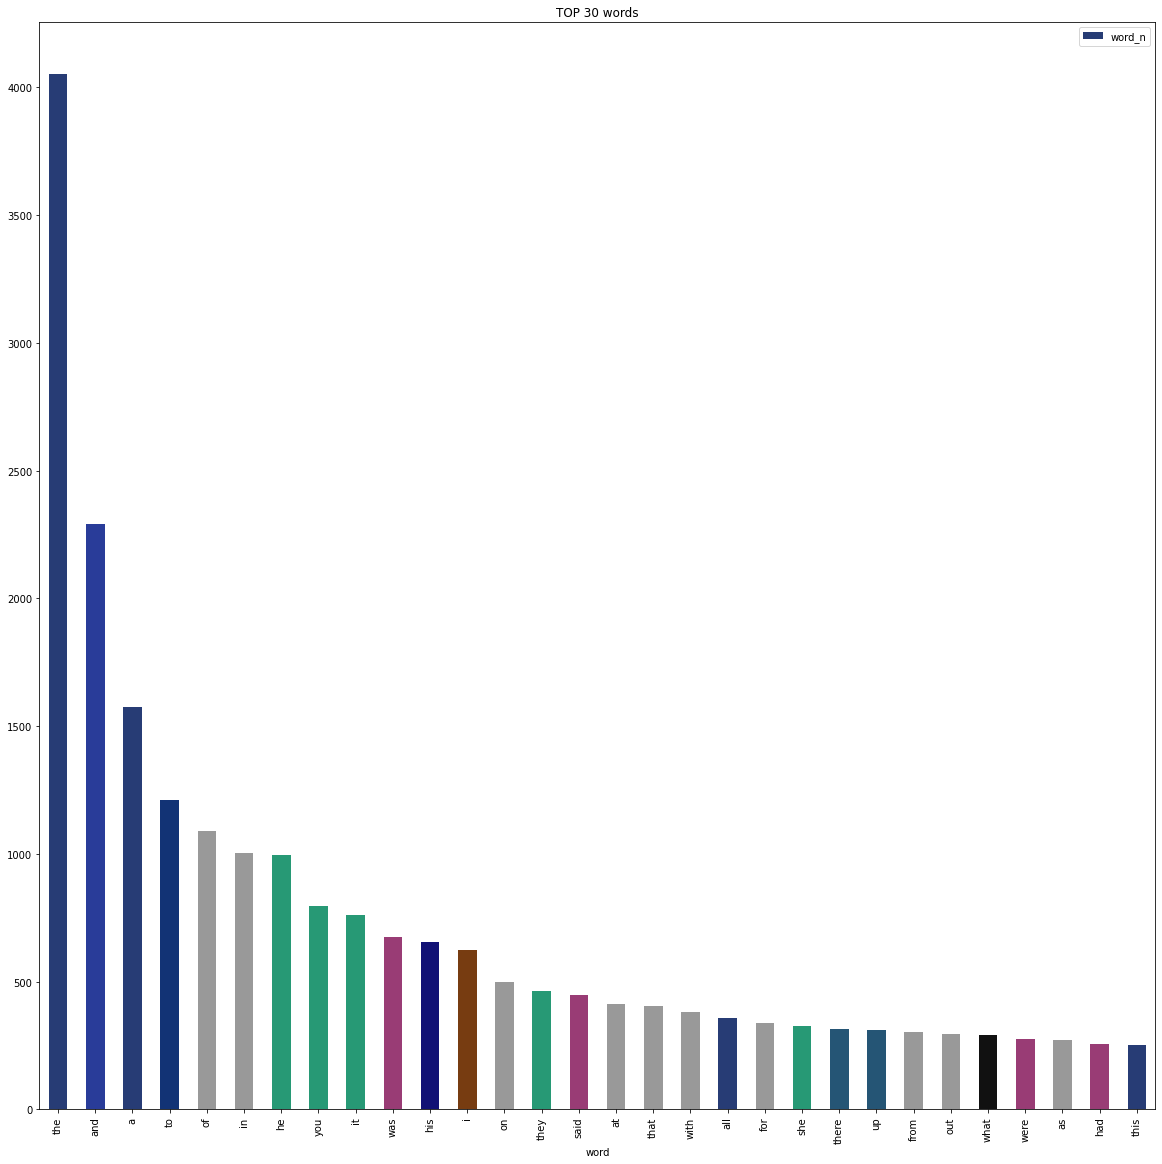

In [222]:
top30 = rb_df.sort_values('word_n', ascending=False).drop_duplicates(subset = "word").head(30)
colors = {'DT':'#273c75', 'CC':'#293c99', 'TO':'#123375', 'IN':'#999999', 'PRP':'#279975', 'VBD':'#993c75', 'PRP$':'#111175', 'NN':'#773c11', 'RB':'#255575', 'WP':'#111111'}
top30.plot.bar(x='word',y='word_n', color=top30['word_pos'].replace(colors),figsize=(20, 20))
plt.title('TOP 30 words')
